# Regression Experiments
_Training regression models to see how well we can predict claimant reliablity, and what features contribute the most to the results_

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from math import sqrt
from util import gather_dataset

In [2]:
df = gather_dataset('./data/claimant_data_processed/')
# remove examples where the score is 0 (could not determine reliability)
df = df[df['score'] != 0]

# group df by task
# df = df.groupby(['task_id'], as_index=False).agg({'score':'mean', 'file_id': 'first', 'sentence': 'first', 'tokens_id': 'first', 'publisher': 'first', 'source': 'first', 'reliability': 'first'})

In [3]:
def create_splits(
    df: pd.DataFrame, train: int = 70, dev: int = 10, test: int = 20
) -> tuple[pd.DataFrame, pd.DataFrame|None, pd.DataFrame]:
    """Split the dataset into a train, dev, and test split using the specified percentages."""

    if (train + dev + test) != 100:
        raise ValueError('The train, dev, and test splits must sum to 100.')

    if not dev:
        print('no dev set\n')
        train_split, test_split = train_test_split(
            df, test_size=test/100, random_state=42
        )
        return train_split, None, test_split
        

    train_split, temp_split = train_test_split(
        df, test_size=(dev + test) / 100, random_state=42
    )

    dev_split, test_split = train_test_split(
        temp_split, test_size=test / (dev + test), random_state=42
    )

    return train_split, dev_split, test_split


train_split, _, test_split = create_splits(df, train=75, dev=0, test=25)
# train_split, _, test_split = create_splits(df)

print(f'Splits length:\ntrain: {len(train_split)}, test: {len(test_split)}')

no dev set

Splits length:
train: 12674, test: 4225


## Baseline

In [4]:
# fit the baseline model
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(train_split['source'], train_split['score']) # type: ignore

# predict on the test set
predictions = dummy_regressor.predict(test_split['source']) # type: ignore

# get MSE
mse = mean_squared_error(test_split['score'], predictions)
rmse = sqrt(mse)
r2 = dummy_regressor.score(test_split['score'], predictions)

baseline_results = {('-'):(mse, rmse, r2)}

print(f'Dummy regressor MSE: {mse:.3f}, RMSE: {rmse:.3f}, R^2: {r2:.3f}')

Dummy regressor MSE: 1.565, RMSE: 1.251, R^2: 1.000


## Regression Models
Here we test different combinations between the following features:
* claimant embeddings
* claimant categories
* publishers
* publisher categories

In [5]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelBinarizer
from itertools import combinations
from typing import Literal, get_args
from tqdm.notebook import tqdm

Feature = Literal['claimant_embeddings', 'claimant_embeddings_context', 'claimant_category', 'publisher', 'publisher_category']

In [6]:
# add all features to the df

# claimant embeddings without context
embeddings_df = pd.read_pickle('./data/claimant_embeddings_deberta-v3-large.pickle')
df = df.merge(embeddings_df[['task_id', 'embeddings']], on='task_id')

# claimant embeddings out of context
df = df.merge(embeddings_df[['task_id', 'context_embeddings']], on='task_id')

# claimant categories
claimant_categories_df = pd.read_csv('./annotations/claimant_annotations.csv')
claimant_categories_df['claimant_type_id'] = claimant_categories_df['ClaimantType'].apply(lambda type_: int(type_.lstrip()[0]))
df = df.merge(claimant_categories_df[['task_id', 'claimant_type_id']], on='task_id')

# publisher categories
publisher_category_df = pd.read_csv('./annotations/publisher_annotations.csv')
df = df.merge(publisher_category_df[['publisher', 'category']], on='publisher')

# rename columns for clarity
df.rename(columns={
    'embeddings': 'claimant_embeddings', 
    'context_embeddings': 'claimant_embeddings_context',
    'category': 'publisher_category'
}, inplace=True)

train_split, _, test_split = create_splits(df, train=75, dev=0, test=25)

train_split.head()

no dev set



,worker_id,task_id,task_response_id,file_id,sentence,tokens_id,publisher,source,reliability,Optional Comments:,batch_no,score,claimant_embeddings,claimant_embeddings_context,claimant_type_id,publisher_category
3613,TC6999WXZFAN,41eaef91-e6e3-4ce6-af99-0cbad583c840,232e11aa-edf8-4ed4-9453-01a15414b88f,Science-News_20170517T164904.conll.annot,138,11 12 13 14 15 16 17,Science News,"Margaret Chan , WHO ’s director-general ,",5 - The source is fully reliable,NaN,5,5,"[-0.3987269103527069, -0.08786825090646744, 0....","[0.4583024453710426, -0.3332920791581273, -0.5...",2,not established
15975,72TDDMF6WWVT,5b55f759-0831-4d9e-b908-36c6fd05fef6,af7bbb40-ba59-4743-a1a4-344e976d0b76,Washington-Post_20170826T112301.conll.annot,34,21,Washington Post,experts,3 - The source is potentially reliable,NaN,6,3,"[-0.36314329504966736, -0.10262235999107361, 0...","[0.03377210721373558, -0.7872453331947327, -0....",5,established
13883,HAYXQNYJXRGJ,1e3efe6b-1430-4379-b017-ebe87bb933dc,ff622606-c3df-47ab-8b2d-a8fc20b8d581,NaturalNews_20170706T012448.conll.annot,20,1,NaturalNews,CNBC,4 - The source is somewhat reliable,NaN,2,4,"[-0.45171961188316345, -0.09075027704238892, 0...","[-0.14901399612426758, -0.6230290532112122, -0...",6,not established
1457,J7JETG7VHPMK,bc415df0-4660-4307-88a3-271474f4ea95,a1a47b3c-54b3-4033-a110-da2e7d76ac61,Parents_20170705T132137.conll.annot,14,4 5 6 7 8 9,Parents,the vast majority of medical experts,3 - The source is potentially reliable,NaN,5,3,"[-0.47777071595191956, -0.03797424957156181, 0...","[-0.06651225437720616, -0.18482298652331033, -...",5,established
15663,GK9EVHKJQMGD,73e0f73b-8371-4433-be28-09ae5c946f26,710fac21-be4d-45e8-b6d5-dadaf2bad6d0,POLITICO_20170925T004222.conll.annot,21,1,POLITICO,Scientists,3 - The source is potentially reliable,NaN,6,3,"[-0.33049726486206055, -0.3993043005466461, 0....","[-0.1998763531446457, 0.24291080236434937, 0.0...",5,established


In [7]:
def create_features(
        df: pd.DataFrame,
        claimant_embeddings: bool = True,
        claimant_embeddings_context: bool = False,
        claimant_category_binarizer: LabelBinarizer|None = None,
        publisher_binarizer: LabelBinarizer|None = None,
        publisher_category_binarizer: LabelBinarizer|None = None,
    ) -> list[list[float|int]]:
    """Uses columns to create a feature array for training the regression model"""

    X = [[] for _ in range(len(df))]
    for idx, (_, row) in enumerate(df.iterrows()):

        # add word embeddings to the feature
        if claimant_embeddings:
            X[idx].extend(list(row['claimant_embeddings'])) # type: ignore

        if claimant_embeddings_context:
            X[idx].extend(list(row['claimant_embeddings_context'])) # type: ignore

        if claimant_category_binarizer: # if a claimant category binarizer was passed, add as feature
            X[idx].extend(claimant_category_binarizer.transform([row['claimant_type_id']])[0])

        if publisher_binarizer: # if a publisher binarizer was passed, add as feature
            X[idx].extend(publisher_binarizer.transform([row['publisher']])[0])

        if publisher_category_binarizer: # if a publisher category binarizer was passed, add as feature
            X[idx].extend(publisher_category_binarizer.transform([row['publisher_category']])[0])
            
        

    return X

# initialize label binarizers
claimant_category_binarizer = LabelBinarizer().fit(df['claimant_type_id'])
publisher_binarizer = LabelBinarizer().fit(df['publisher'])
publisher_category_binarizer = LabelBinarizer().fit(df['publisher_category'])

binarizers: dict[Feature, LabelBinarizer] = {'claimant_category': claimant_category_binarizer, 'publisher': publisher_binarizer, 'publisher_category': publisher_category_binarizer}

In [44]:
MSE = float
RSQUARED = float

def run_experiment(train_split: pd.DataFrame, test_split: pd.DataFrame, binarizers: dict[Feature, LabelBinarizer], features: tuple[Feature,...], model:LinearSVR|LinearRegression) -> tuple[MSE, RSQUARED]:
    """Extracts the correct features, trains a regression model, and returns the MSE on the test set"""

    # create features for the train split
    X_train = create_features(
        train_split,
        claimant_embeddings=True if 'claimant_embeddings' in features else False,
        claimant_embeddings_context=True if 'claimant_embeddings_context' in features else False,
        claimant_category_binarizer=binarizers['claimant_category'] if 'claimant_category' in features else None,
        publisher_binarizer=binarizers['publisher'] if 'publisher' in features else None,
        publisher_category_binarizer=binarizers['publisher_category'] if 'publisher_category' in features else None,
    )
    y_train = list(train_split['score'])

    # fit the model
    model.fit(X_train, y_train)

    # create features for the test split
    X_test = create_features(
        test_split,
        claimant_embeddings=True if 'claimant_embeddings' in features else False,
        claimant_embeddings_context=True if 'claimant_embeddings_context' in features else False,
        claimant_category_binarizer=binarizers['claimant_category'] if 'claimant_category' in features else None,
        publisher_binarizer=binarizers['publisher'] if 'publisher' in features else None,
        publisher_category_binarizer=binarizers['publisher_category'] if 'publisher_category' in features else None,
    )
    y_test = list(test_split['score'])

    # predict the test split using the model
    predictions = model.predict(X_test)

    # compute and return measures
    mse = mean_squared_error(y_test, predictions)
    r2 = model.score(X_test, y_test)

    return mse, r2

# code to test function definition
model = LinearRegression()
mse, r2 = run_experiment(train_split, test_split, binarizers, ('claimant_embeddings', 'publisher'), model)
rmse = sqrt(mse)
print(f'Test experiment MSE: {mse:.3f}, RMSE: {rmse:.3f} and R2: {r2:.3f}')

Test experiment MSE: 1.002, RMSE: 1.001 and R2: 0.360


In [9]:
# run experiment for all combinations of features 
features = get_args(Feature)
feature_combinations = tuple(combination for num in range(1, len(features) + 1) for combination in combinations(features, num))
# remove occurances where both types of embeddings occur together
feature_combinations = tuple(combination for combination in feature_combinations if not ('claimant_embeddings' in combination and 'claimant_embeddings_context' in combination))

In [10]:
features_df = df[['claimant_embeddings', 'claimant_embeddings_context', 'claimant_type_id', 'publisher', 'publisher_category']]
features_df.head()

,claimant_embeddings,claimant_embeddings_context,claimant_type_id,publisher,publisher_category
0,"[-0.3007359802722931, -0.060107577592134476, 0...","[0.21119636182601637, -0.3454102518287702, 0.0...",2,ThinkProgress,not established
1,"[-0.3007359802722931, -0.060107577592134476, 0...","[0.21119636182601637, -0.3454102518287702, 0.0...",2,ThinkProgress,not established
2,"[-0.5612852573394775, -0.03220456838607788, 0....","[0.17742657661437988, -0.19991786777973175, 0....",6,PublicHealth.org,established
3,"[-0.3007359802722931, -0.060107577592134476, 0...","[0.21119636182601637, -0.3454102518287702, 0.0...",2,ThinkProgress,not established
4,"[-0.5341578125953674, -0.10339929163455963, 0....","[-0.5530586391687393, 0.4381181299686432, 0.44...",2,National Vaccine Information Center (NVIC),governmental/institutional


In [188]:
# test for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_scores = {feature: None for feature in features}

# print([variance_inflation_factor(features_df.values, i) for i in range(len(features_df.columns))])

print(f'{"feature":30}{"VIF"}')
print('---'*15)
for feature, vif_score in vif_scores.items():
    print(f'{feature:30}{vif_score}')

feature                       VIF
---------------------------------------------
claimant_embeddings           None
claimant_embeddings_context   None
claimant_category             None
publisher                     None
publisher_category            None


In [189]:
# run linear regression model
model = LinearRegression()
linear_regression_results = {}
for feature_combination in tqdm(feature_combinations, desc='Running Linear Regression experiments'):
    mse, r2 = run_experiment(train_split, test_split, binarizers, feature_combination, model)
    rmse = sqrt(mse)
    linear_regression_results[feature_combination] = (mse, rmse, r2)

# print results in order of best performing
for combination, (mse, rmse, r2) in  sorted(linear_regression_results.items(), key=lambda x: x[1]):
    print(f'{" & ".join(combination):_<80} MSE: {mse:.5f} RMSE: {rmse:.5f} R2: {r2:.5f}')

Running Linear Regression experiments:   0%|          | 0/23 [00:00<?, ?it/s]

claimant_embeddings & publisher_________________________________________________ MSE: 1.00221 RMSE: 1.00111 R2: 0.35953
claimant_embeddings & publisher & publisher_category____________________________ MSE: 1.00238 RMSE: 1.00119 R2: 0.35943
claimant_embeddings & claimant_category & publisher & publisher_category________ MSE: 1.00303 RMSE: 1.00151 R2: 0.35901
claimant_embeddings & claimant_category & publisher_____________________________ MSE: 1.00315 RMSE: 1.00157 R2: 0.35893
claimant_embeddings_context & publisher & publisher_category____________________ MSE: 1.00830 RMSE: 1.00414 R2: 0.35564
claimant_embeddings_context & publisher_________________________________________ MSE: 1.00844 RMSE: 1.00421 R2: 0.35555
claimant_embeddings & publisher_category________________________________________ MSE: 1.00848 RMSE: 1.00423 R2: 0.35553
claimant_embeddings & claimant_category & publisher_category____________________ MSE: 1.00935 RMSE: 1.00466 R2: 0.35497
claimant_embeddings_context & claimant_c

In [190]:
# print results in overleaf table format
backslash_ampersand = ' \\& '
eol = '\\\\'

print(f'{"feature(s)":^85}   {"RMSE":^5}    {"R2":^5}')
for combination, (_, rmse, r2) in  sorted(linear_regression_results.items(), key=lambda x: x[1]):
    print(f'{backslash_ampersand.join([feature.replace("_", " ") for feature in combination]):85} & {rmse:.3f} & {r2:>6.3f} {eol}')

                                     feature(s)                                         RMSE      R2  
claimant embeddings \& publisher                                                      & 1.001 &  0.360 \\
claimant embeddings \& publisher \& publisher category                                & 1.001 &  0.359 \\
claimant embeddings \& claimant category \& publisher \& publisher category           & 1.002 &  0.359 \\
claimant embeddings \& claimant category \& publisher                                 & 1.002 &  0.359 \\
claimant embeddings context \& publisher \& publisher category                        & 1.004 &  0.356 \\
claimant embeddings context \& publisher                                              & 1.004 &  0.356 \\
claimant embeddings \& publisher category                                             & 1.004 &  0.356 \\
claimant embeddings \& claimant category \& publisher category                        & 1.005 &  0.355 \\
claimant embeddings context \& claimant category 

In [191]:
# run more robust LinearSVR model
model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
linear_svr_results = {}
for feature_combination in tqdm(feature_combinations, desc='Running LinearSVR experiments'):
    mse, r2 = run_experiment(train_split, test_split, binarizers, feature_combination, model)
    rmse = sqrt(mse)
    linear_svr_results[feature_combination] = (mse, rmse, r2)

# print results in order of best performing
for combination, (mse, rmse, r2) in  sorted(linear_svr_results.items(), key=lambda x: x[1]):
    print(f'{" & ".join(combination):_<80} MSE: {mse:.5f} RMSE: {rmse:.5f} R2: {r2:.5f}')

Running LinearSVR experiments:   0%|          | 0/23 [00:00<?, ?it/s]

claimant_embeddings & claimant_category & publisher & publisher_category________ MSE: 0.97591 RMSE: 0.98788 R2: 0.37634
claimant_embeddings & claimant_category & publisher_____________________________ MSE: 0.98109 RMSE: 0.99050 R2: 0.37303
claimant_embeddings & publisher & publisher_category____________________________ MSE: 0.98847 RMSE: 0.99422 R2: 0.36831
claimant_embeddings_context & claimant_category & publisher_____________________ MSE: 0.99207 RMSE: 0.99602 R2: 0.36601
claimant_embeddings & publisher_________________________________________________ MSE: 0.99528 RMSE: 0.99763 R2: 0.36396
claimant_embeddings_context & publisher_________________________________________ MSE: 0.99735 RMSE: 0.99868 R2: 0.36264
claimant_embeddings_context_____________________________________________________ MSE: 0.99784 RMSE: 0.99892 R2: 0.36233
claimant_embeddings_context & publisher & publisher_category____________________ MSE: 0.99989 RMSE: 0.99994 R2: 0.36101
claimant_embeddings_context & claimant_c

In [192]:
# print results in overleaf table format
print(f'{"feature(s)":^85}   {"RMSE":^5}    {"R2":^5}')
for combination, (_, rmse, r2) in  sorted(linear_svr_results.items(), key=lambda x: x[1]):
    print(f'{backslash_ampersand.join([feature.replace("_", " ") for feature in combination]):85} & {rmse:.3f} & {r2:>6.3f} {eol}')

                                     feature(s)                                         RMSE      R2  
claimant embeddings \& claimant category \& publisher \& publisher category           & 0.988 &  0.376 \\
claimant embeddings \& claimant category \& publisher                                 & 0.991 &  0.373 \\
claimant embeddings \& publisher \& publisher category                                & 0.994 &  0.368 \\
claimant embeddings context \& claimant category \& publisher                         & 0.996 &  0.366 \\
claimant embeddings \& publisher                                                      & 0.998 &  0.364 \\
claimant embeddings context \& publisher                                              & 0.999 &  0.363 \\
claimant embeddings context                                                           & 0.999 &  0.362 \\
claimant embeddings context \& publisher \& publisher category                        & 1.000 &  0.361 \\
claimant embeddings context \& claimant category 

In [193]:
# run ridge regression model
model = Ridge()
ridge_results = {}
for feature_combination in tqdm(feature_combinations, desc='Running Linear Regression experiments'):
    mse, r2 = run_experiment(train_split, test_split, binarizers, feature_combination, model)
    rmse = sqrt(mse)
    ridge_results[feature_combination] = (mse, rmse, r2)

# print results in order of best performing
for combination, (mse, rmse, r2) in  sorted(ridge_results.items(), key=lambda x: x[1]):
    print(f'{" & ".join(combination):_<80} MSE: {mse:.5f} RMSE: {rmse:.5f} R2: {r2:.5f}')

Running Linear Regression experiments:   0%|          | 0/23 [00:00<?, ?it/s]

claimant_embeddings & claimant_category & publisher_____________________________ MSE: 0.97051 RMSE: 0.98515 R2: 0.37979
claimant_embeddings & claimant_category & publisher & publisher_category________ MSE: 0.97072 RMSE: 0.98525 R2: 0.37965
claimant_embeddings & publisher_________________________________________________ MSE: 0.97508 RMSE: 0.98746 R2: 0.37687
claimant_embeddings & publisher & publisher_category____________________________ MSE: 0.97529 RMSE: 0.98757 R2: 0.37674
claimant_embeddings_context_____________________________________________________ MSE: 0.99712 RMSE: 0.99856 R2: 0.36279
claimant_embeddings_context & claimant_category_________________________________ MSE: 0.99774 RMSE: 0.99887 R2: 0.36239
claimant_embeddings & claimant_category & publisher_category____________________ MSE: 0.99874 RMSE: 0.99937 R2: 0.36175
claimant_embeddings_context & publisher_________________________________________ MSE: 0.99898 RMSE: 0.99949 R2: 0.36160
claimant_embeddings_context & claimant_c

In [204]:
# print combined results in overleaf table format

# dict of model name as key and results dict as value
combined_results = {'linear regression': linear_regression_results, 'linear SVR':linear_svr_results, 'baseline': baseline_results}

# restructure the dataset
combined_results_formatted = {}
for model_name, feature_results in combined_results.items():
    for features, results in feature_results.items():
        combined_results_formatted[(model_name, features)] = results

found_highest = {model_name: False for model_name in combined_results.keys() if model_name != 'baseline'}

backslash = '\\'

# print sorted by mse
print(f'{"model name":^20}   {"feature(s)":^85}   {"RMSE":^5}    {"R2":^5}')
for position, ((model_name, features), (_, rmse, r2)) in  enumerate(sorted(combined_results_formatted.items(), key=lambda x: x[1]), 1):
    # print the baseline in italics
    if model_name == 'baseline':
        print(f'{position:<2} & { backslash + "textit{" + model_name + "}":<20} & {backslash + "textit{"+ backslash_ampersand.join([feature.replace("_", " ") for feature in features])+"}":85} & \\textit{{{rmse:.3f}}} & \\textit{{{r2:>6.3f}}} {eol}')
    # print the best results in bold
    elif not found_highest[model_name]:
        print(f'{position:<2} & { backslash + "textbf{" + model_name + "}":<20} & {backslash + "textbf{"+ backslash_ampersand.join([feature.replace("_", " ") for feature in features])+"}":85} & \\textbf{{{rmse:.3f}}} & \\textbf{{{r2:>6.3f}}} {eol}')
        found_highest[model_name] = True
    # print the rest without anything special
    else:
        print(f'{position:<2} & {model_name:<20} & {backslash_ampersand.join([feature.replace("_", " ") for feature in features]):85} & {rmse:.3f} & {r2:>6.3f} {eol}')

     model name                                             feature(s)                                         RMSE      R2  
1  & \textbf{linear SVR}  & \textbf{claimant embeddings \& claimant category \& publisher \& publisher category}  & \textbf{0.988} & \textbf{ 0.376} \\
2  & linear SVR           & claimant embeddings \& claimant category \& publisher                                 & 0.991 &  0.373 \\
3  & linear SVR           & claimant embeddings \& publisher \& publisher category                                & 0.994 &  0.368 \\
4  & linear SVR           & claimant embeddings context \& claimant category \& publisher                         & 0.996 &  0.366 \\
5  & linear SVR           & claimant embeddings \& publisher                                                      & 0.998 &  0.364 \\
6  & linear SVR           & claimant embeddings context \& publisher                                              & 0.999 &  0.363 \\
7  & linear SVR           & claimant embeddings cont

## Error analysis

,true,pred
0,3,2.688171
1,4,2.515808
2,1,2.799011
3,1,1.753601
4,3,3.984558
...,...,...
4220,3,3.200867
4221,3,1.599304
4222,5,4.203064
4223,3,3.367615


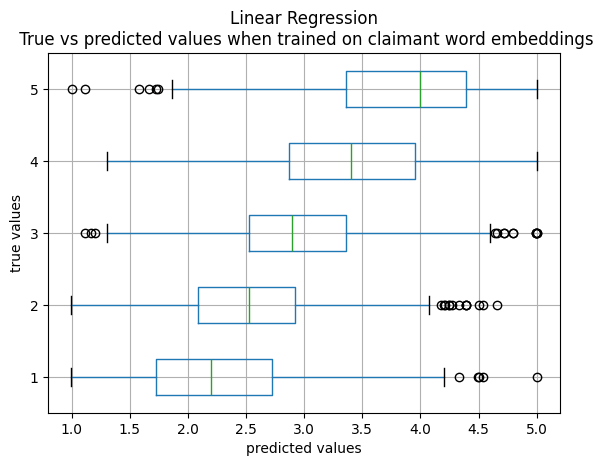

In [68]:
def error_analysis(train_split: pd.DataFrame, test_split: pd.DataFrame, binarizers: dict[Feature, LabelBinarizer], features: tuple[Feature,...], model:LinearSVR|LinearRegression, plot_predictions: bool = False, plt_title: str|None = None) -> pd.DataFrame:
    """Runs the same experiment as run_experiment(), but then plots the predicted values against the true values"""

    # create features for the train split
    X_train = create_features(
        train_split,
        claimant_embeddings=True if 'claimant_embeddings' in features else False,
        claimant_embeddings_context=True if 'claimant_embeddings_context' in features else False,
        claimant_category_binarizer=binarizers['claimant_category'] if 'claimant_category' in features else None,
        publisher_binarizer=binarizers['publisher'] if 'publisher' in features else None,
        publisher_category_binarizer=binarizers['publisher_category'] if 'publisher_category' in features else None,
    )
    y_train = list(train_split['score'])

    # fit the model
    model.fit(X_train, y_train)

    # create features for the test split
    X_test = create_features(
        test_split,
        claimant_embeddings=True if 'claimant_embeddings' in features else False,
        claimant_embeddings_context=True if 'claimant_embeddings_context' in features else False,
        claimant_category_binarizer=binarizers['claimant_category'] if 'claimant_category' in features else None,
        publisher_binarizer=binarizers['publisher'] if 'publisher' in features else None,
        publisher_category_binarizer=binarizers['publisher_category'] if 'publisher_category' in features else None,
    )
    y_test = list(test_split['score'])

    # predict the test split using the model
    predictions = model.predict(X_test)
    
    plot_df = pd.DataFrame({'true': y_test, 'pred': predictions})

    # return early if plot is not needed
    if not plot_predictions: 
        return plot_df 

    plot = plot_df.boxplot('pred', by='true', vert=False)
    plot.set_ylabel('true values')
    plot.set_xlabel('predicted values')

    if plt_title:
        plt.suptitle('') 
        plot.set_title(plt_title)

    return plot_df

model = LinearRegression()
error_analysis(train_split, test_split, binarizers, ('claimant_embeddings',), model, plot_predictions=True, plt_title='Linear Regression\n True vs predicted values when trained on claimant word embeddings')

In [70]:
# get results needed for combined plot
model = LinearRegression()
regression_embeddings_err_df = error_analysis(train_split, test_split, binarizers, ('claimant_embeddings',), model, plt_title='Linear Regression\n True vs predicted values when trained on claimant word embeddings')
regression_embeddings_context_err_df = error_analysis(train_split, test_split, binarizers, ('claimant_embeddings_context',), model, plt_title='Linear Regression\n True vs predicted values when trained on claimant word embeddings')

model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
svr_embeddings_err_df = error_analysis(train_split, test_split, binarizers, ('claimant_embeddings',), model, plt_title='Linear Regression\n True vs predicted values when trained on claimant word embeddings')
svr_embeddings_context_err_df = error_analysis(train_split, test_split, binarizers, ('claimant_embeddings_context',), model, plt_title='Linear Regression\n True vs predicted values when trained on claimant word embeddings')

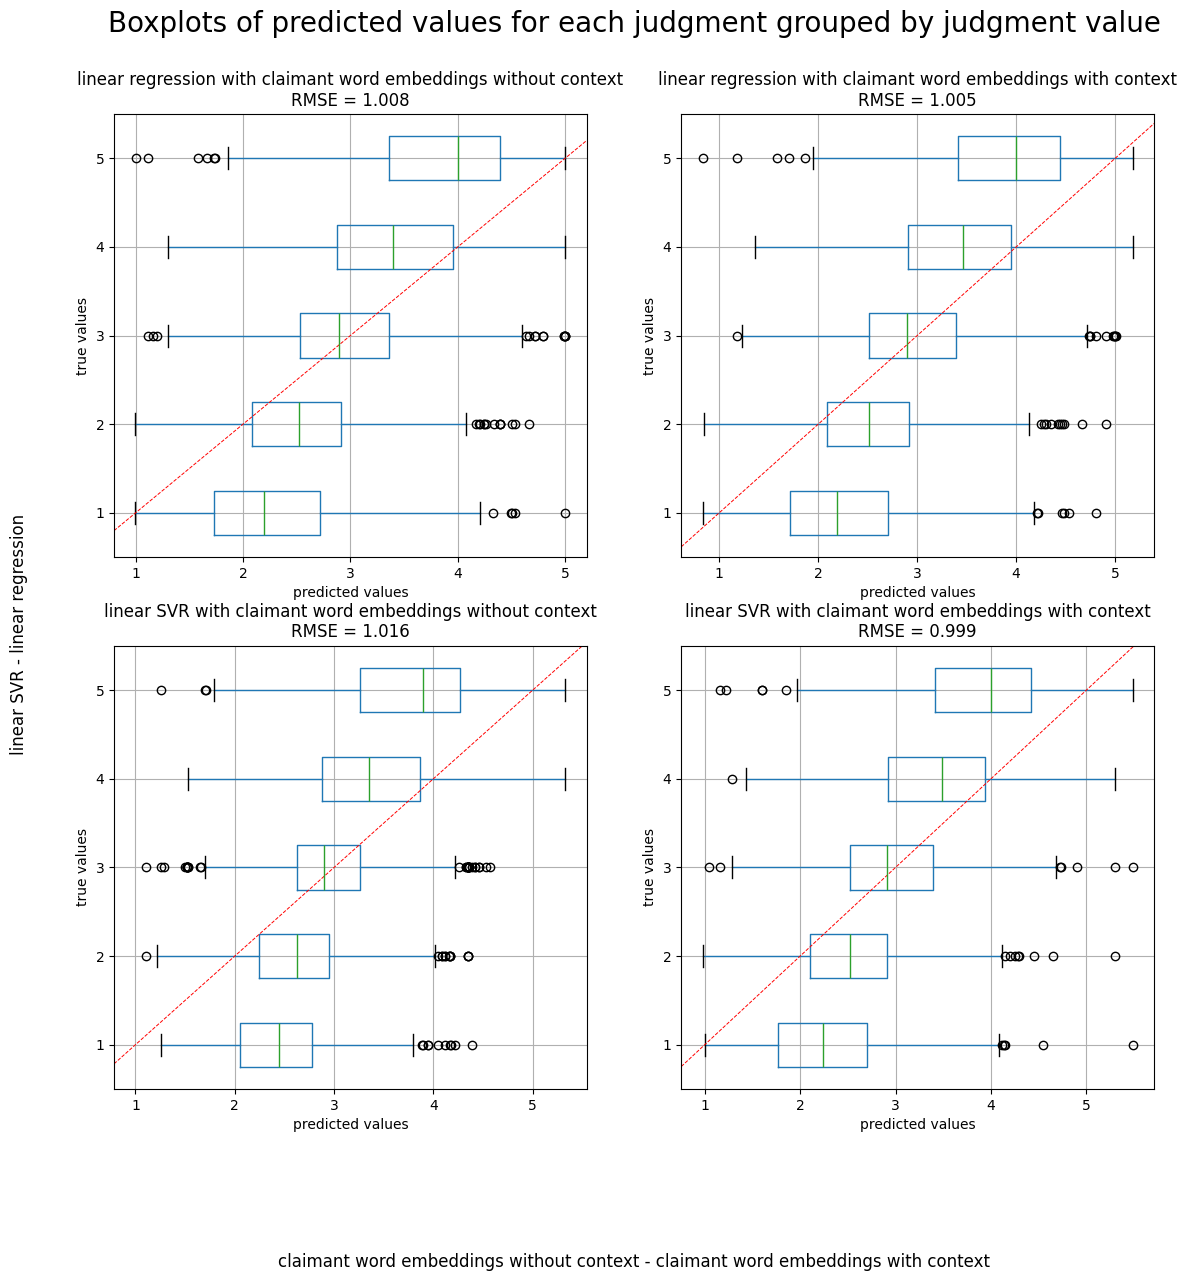

In [132]:
# plot each results
fig, ax = plt.subplots(2, 2, figsize=(13,13))

plot = regression_embeddings_err_df.boxplot('pred', by='true', vert=False, ax=ax[0][0])
plot.set_ylabel('true values')
plot.set_xlabel('predicted values')
plot.set_xticks([1,2,3,4,5])
plot.set_title('linear regression with claimant word embeddings without context\nRMSE = 1.008') 

plot = regression_embeddings_context_err_df.boxplot('pred', by='true', vert=False, ax=ax[0][1])
plot.set_ylabel('true values')
plot.set_xlabel('predicted values')
plot.set_xticks([1,2,3,4,5])
plot.set_title('linear regression with claimant word embeddings with context\nRMSE = 1.005') 

plot = svr_embeddings_err_df.boxplot('pred', by='true', vert=False, ax=ax[1][0])
plot.set_ylabel('true values')
plot.set_xlabel('predicted values')
plot.set_xticks([1,2,3,4,5])
plot.set_title('linear SVR with claimant word embeddings without context\nRMSE = 1.016') 

plot = svr_embeddings_context_err_df.boxplot('pred', by='true', vert=False, ax=ax[1][1])
plot.set_ylabel('true values')
plot.set_xlabel('predicted values')
plot.set_xticks([1,2,3,4,5])
plot.set_title('linear SVR with claimant word embeddings with context\nRMSE = 0.999') 

for x, y in ((0,0), (0,1), (1,0), (1,1)):
    ax[x][y].axline([1, 1], [5, 5], color='red', linestyle='--', linewidth=0.7)

fig.suptitle('Boxplots of predicted values for each judgment grouped by judgment value', fontsize=20)
fig.supxlabel('claimant word embeddings without context - claimant word embeddings with context')
fig.supylabel('linear SVR - linear regression')

plt.show()